<a href="https://colab.research.google.com/github/Hakira133/Flask_docker_project/blob/master/MagicRenko_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 7.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Class Renko
вход: pd.DataFrame - данные (тиковые или свечи) обязательные столбец - цены, по которым строим + datetime. Опциональные столбцы - Объемы
  функции:

  1) строить свечи по истории  
     опции:  
      a)- с учетом гепов/без учета гепов  
      б)+ с учетом объемов/без учета объемов  
      в)- с нумбой(быстро)/без нумбы  
  2)+ добавлять по 1 точке  
  3) рисовать полученные свечи  
     опции:   
      а)+ с виксами/без виксов  
      б)+ с обычными свечами/ без  
      в)- интерактивный/ не интерактивный  
      г)?! сохранение в файл/ вывод на экран  

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import datetime

import yfinance as yf

In [ ]:
def get_asset(ticker, start_date, end_date):
  df = yf.download(ticker, start=start_date, end=end_date, progress=False)
  df = pd.DataFrame(df)
  print(df.columns)
  df['price'] = df['Close']
  df['volume'] = df['Volume']
  df.dropna(inplace=True)
  return df[['price', 'volume']]



# Renko Class

In [ ]:
class RenkoBasic:
  """Creates classic/flex renko bars from ticks or classic candles data
    Atrributes:
        renko_type: 'classic'/'flex'

        params:
            classic renko chart: brick_size
            flex renko chart: bar_size
                              trend_offset (0; bar_size)
                              reversal_offset (0; bar_size)

        methods:
          set_params(**params)
          build_history(data: pd.DataFrame)
          add_history(data_to_add: pd.DataFrame)
          paired_plot_renko(path_to_save: str)
          plot_renko(path_to_save: str, wicks_plot: bool = False)

  """
  def __init__(self): 
    #renko_type - 'classic'/'flex'
    self.price_column = 'price'
    self.volume_column = 'volume'

 
  def check_data(self, data_columns: list) -> bool:
    self.calculate_volume = self.volume_column in data_columns
    if self.price_column in data_columns:
      return True
    return False

  def build_history(self, prices):
    self.source_data = prices
    correct_data = self.check_data(prices.columns.to_list())
    assert correct_data, """Data does not contain 'price' column"""

    self.source_prices = pd.Series(self.source_data.loc[:,self.price_column])
    self.renko_prices = [(float(self.source_prices[0]), float(self.source_prices[0]))] 
    self.renko_directions = [0]
    self.renko_index = [self.source_prices.index[0]]

    i = 1
    while (i < len(self.source_prices)):
        goto_next_price = False
        last_price = self.source_prices[i]

        # check price and append new bar if needed
        goto_next_price = self._renko_rule(last_price, self.source_prices.index[i])

        # if there is no new bar, take next price
        if goto_next_price:
          i += 1

    self.renko_bars = pd.DataFrame(self.renko_prices[1:], columns = ['open', 'close'], index = self.renko_index[1:])
    if self.calculate_volume:
      self.__count_renko_volumes()

    return len(self.renko_prices)

  def __count_renko_volumes(self):
    unique_idx = np.unique(self.renko_index)
    unique_volumes = self.source_data[self.volume_column].groupby(pd.cut(self.source_data.index, bins=unique_idx)).sum()
    repeats = self.renko_bars.groupby(level=0).count().iloc[:,0].values
    self.renko_bars.loc[:, 'volume'] = np.repeat(unique_volumes.values, repeats, axis=0)
    self.renko_bars['volume'] = self.renko_bars['volume']/np.repeat(repeats, repeats, axis=0)


  def add_history(self, data_to_add):
    if len(self.renko_prices) == 0:
      self.source_data = data_to_add
      self.source_prices = self.source_data['price']
      self.renko_prices = [(self.source_prices[0],  self.source_prices[0])]
      self.renko_directions = [0]
      return 1
    else:
      self.source_data = self.source_data.append(data_to_add)
      self.source_prices = self.source_prices.append(data_to_add['price'])
      price_to_add = data_to_add['price']

      i = 0
      while (i < len(price_to_add)):
        goto_next_price = False
        last_price = price_to_add[i]

        # check price and append new bar if needed
        goto_next_price = self._renko_rule(last_price, price_to_add.index[i])

        # if there is no new bar, take next price
        if goto_next_price:
          i += 1

    self.renko_bars = pd.DataFrame(self.renko_prices[1:], columns = ['open', 'close'], index = self.renko_index[1:])
    if self.calculate_volume:
      self.__count_renko_volumes()


  def paired_plot_renko(self, path_to_save: str, col_up='g', col_down='r', figsize=(18,6)):
      ax_price_pos = 0
      ax_renko_pos = 1  

      fig, ax = plt.subplots(figsize=figsize, nrows=2)
      ax[ax_renko_pos].set_title('Renko chart')
      ax[ax_price_pos].set_title('Raw data chart')
      brick_size = np.max(np.abs(self.renko_bars['close']-self.renko_bars['open']))

      # Calculate the limits of axes
      ax[ax_renko_pos].set_xlim(0.0, len(self.renko_bars) + 2.0)
      ax[ax_renko_pos].set_ylim(np.min(self.renko_bars[['open', 'close']].values) - 1.0 * brick_size, 
                            np.max(self.renko_bars[['open', 'close']].values) + 1.0 * brick_size)
      
      # Plot each renko bar
      start_point = self.source_data.index[0]
      for i in range(len(self.renko_bars)):

          # Set basic params for patch rectangle
          col = col_up if self.renko_directions[i+1] >= 0 else col_down
          open, close = self.renko_bars.loc[:, ['open','close']].values[i]

          x = i + 1
          y = open if self.renko_directions[i+1] == 1 else close
          height = np.abs(open - close)

          # Draw bar with params
          ax[ax_renko_pos].add_patch(
              patches.Rectangle(
                  (x, y),   # (x,y)
                  1.0,     # width
                  height, # height
                  facecolor = col
              )
          )
          
      ax[ax_price_pos].plot(self.source_data[self.price_column])
      leg_up = True
      leg_down = True

      for i in range(len(self.renko_bars)):
        if self.renko_directions[i+1] == 1:
            c = 'g'
        else:
            c = 'r'

        if i > 0:
          start_point = self.renko_bars.index[i-1]
        end_point = self.renko_bars.index[i]

        if leg_up and (c == 'g'):
          ax[ax_price_pos].axvspan(start_point,end_point, label = 'Renko Upside Bar Built', color = c, alpha = .2, ec=None)
          leg_up = False

        elif leg_down and (c == 'r'):
          ax[ax_price_pos].axvspan(start_point,end_point, label = 'Renko Downside Bar Built', color = c, alpha = .2, ec=None)
          leg_down = False

        else:
          ax[ax_price_pos].axvspan(start_point,end_point, color = c, alpha = .2, ec=None)

      ax[ax_price_pos].legend(bbox_to_anchor=(1.01,1), loc="upper left", borderaxespad=0)
      plt.tight_layout()
      #plt.savefig(path_to_save)
      plt.show()

  def plot_renko(self, path_to_save: str, wicks_plot: bool = False, col_up='g', col_down='r', figsize=(18,6)):
      fig, ax = plt.subplots(figsize=figsize)
      ax.set_title('Renko chart')
      brick_size = np.max(np.abs(self.renko_bars['close']-self.renko_bars['open']))

      # Calculate the limits of axes
      ax.set_xlim(0.0, len(self.renko_bars) + 2.0)
      ax.set_ylim(np.min(self.renko_bars[['open', 'close']].values) - 1.0 * brick_size, 
                            np.max(self.renko_bars[['open', 'close']].values) + 1.0 * brick_size)
    
    # Calculating borders for plotting wicks
      if wicks_plot:
        unique_idx = np.unique(self.renko_index)
        repeats = self.renko_bars.groupby(level=0).count().iloc[:,0].values
        max_prices = self.source_data[self.price_column].groupby(pd.cut(self.source_data.index, bins=unique_idx)).max().values
        max_prices = np.repeat(max_prices, repeats, axis=0)
        max_prices = np.where(np.concatenate((self.renko_bars.index[1:] != self.renko_bars.index[:-1], [True])), 
                              max_prices, 
                              self.renko_bars.open)
 
        min_prices = self.source_data[self.price_column].groupby(pd.cut(self.source_data.index, bins=unique_idx)).min().values
        min_prices = np.repeat(min_prices, repeats, axis=0)
        min_prices = np.where(np.concatenate((self.renko_bars.index[:-1] != self.renko_bars.index[1:], [True])), 
                              min_prices, 
                              self.renko_bars.open)
        min_prices = np.minimum(min_prices, self.renko_bars[['open', 'close']].values.min(axis=1))
        
      # Plot each renko bar
      for i in range(len(self.renko_bars)):

          # Set basic params for patch rectangle
          col = col_up if self.renko_directions[i+1] >= 0 else col_down
          open, close = self.renko_bars.loc[:, ['open','close']].values[i]

          x = i + 1
          y = open if self.renko_directions[i+1] == 1 else close
          height = np.abs(open - close)

          # Draw bar with params
          ax.add_patch(
              patches.Rectangle(
                  (x, y),   # (x,y)
                  1.0,     # width
                  height, # height
                  facecolor = col
              )
          )
          
          if wicks_plot:
              x = i + 1.475
              y = min_prices[i]
              height = max_prices[i] - min_prices[i]

              ax.add_patch(
                  patches.Rectangle(
                      (x, y),   # (x,y)
                      0.05,     # width
                      height, # height
                      facecolor = col
                  )
              )
          
      plt.tight_layout()
      #plt.savefig(path_to_save)
      plt.show()


class RenkoClassic(RenkoBasic):
  def set_params(self, **params):
      assert 'brick_size' in params.keys(), 'Required parameter brick_size is missing'
      self.brick_size = params['brick_size']
      
  def _renko_rule(self, last_price, idx):
      processing_flag = False

    #Get direction-dependent bounds for next renko bar
      if self.renko_directions[-1] == 0:
          start_price_up = self.renko_prices[-1][1]
          end_price_up = self.renko_prices[-1][1] + self.brick_size
          start_price_down = self.renko_prices[-1][1]
          end_price_down = self.renko_prices[-1][1] - self.brick_size

      elif self.renko_directions[-1] == 1:
          start_price_up = self.renko_prices[-1][1]
          end_price_up = self.renko_prices[-1][1] + self.brick_size
          start_price_down = self.renko_prices[-1][0]
          end_price_down = self.renko_prices[-1][0] - self.brick_size

      elif  self.renko_directions[-1] == -1:
          start_price_up = self.renko_prices[-1][0]
          end_price_up = self.renko_prices[-1][0] + self.brick_size
          start_price_down = self.renko_prices[-1][1]
          end_price_down = self.renko_prices[-1][1] - self.brick_size

    # appending next renko bar or getting next asset price
      if last_price >= end_price_up:
          self.renko_directions.append(1)
          self.renko_prices.append((start_price_up, end_price_up))
          self.renko_index.append(idx)

      elif last_price <= end_price_down:  
          self.renko_directions.append(-1)
          self.renko_prices.append((start_price_down, end_price_down))
          self.renko_index.append(idx)

      else:
          processing_flag = True 

      return processing_flag


class RenkoFlex(RenkoBasic):
  def set_params(self, **params):
      assert 'bar_size' in params.keys(), 'Required parameter bar_size is missing'
      assert 'trend_offset' in params.keys(), 'Required parameter trend_offset is missing'
      assert 'reversal_offset' in params.keys(), 'Required parameter brick_size is missing'
      self.bar_size = params['bar_size']
      self.trend_offset = params['trend_offset']
      self.reversal_offset = params['reversal_offset']

  def _renko_rule(self, last_price, idx):
    #def flex_renko_rule(last_price, renko_prices, renko_directions, bar_size, trend_offset, reversal_offset):
      processing_flag = False
    #Get direction-dependent bounds for next renko bar

      if self.renko_directions[-1] == 0:
          start_price_up = self.renko_prices[-1][1]
          end_price_up = self.renko_prices[-1][1]*(1+self.bar_size)
          start_price_down = self.renko_prices[-1][1]
          end_price_down = self.renko_prices[-1][1]*(1-self.bar_size)

      elif self.renko_directions[-1] == 1:
          start_price_up = self.renko_prices[-1][1]*(1 - self.trend_offset)
          end_price_up = self.renko_prices[-1][1]*(1 + self.bar_size - self.trend_offset)
          start_price_down = self.renko_prices[-1][0]*(1 + self.reversal_offset)
          end_price_down = self.renko_prices[-1][0]*(1 + self.reversal_offset - self.bar_size)

      elif  self.renko_directions[-1] == -1:
          start_price_up = self.renko_prices[-1][0]*(1 - self.reversal_offset)
          end_price_up = self.renko_prices[-1][0]*(1 - self.reversal_offset + self.bar_size)
          start_price_down = self.renko_prices[-1][1]*(1 + self.trend_offset)
          end_price_down = self.renko_prices[-1][1]*(1 + self.trend_offset - self.bar_size)

    # appending next renko bar or getting next asset price
      if last_price >= end_price_up:
          self.renko_directions.append(1)
          self.renko_prices.append((start_price_up, end_price_up))
          self.renko_index.append(idx)


      elif last_price <= end_price_down:  
          self.renko_directions.append(-1)
          self.renko_prices.append((start_price_down, end_price_down))
          self.renko_index.append(idx)

      else:
          processing_flag = True 

      return processing_flag


# Load data

In [ ]:
START = '1993-01-01'
END = '2022-01-01'
data = get_asset("SPY", START, END)
data.head(4)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,price,volume
Date,,
1993-01-29,43.93750,1003200
1993-02-01,44.25000,480500
1993-02-02,44.34375,201300
1993-02-03,44.81250,529400


# Test classic Renko

                open     close        volume
1995-06-13   43.9375   53.9375  1.790986e+08
1996-02-05   53.9375   63.9375  6.392890e+07
1996-11-14   63.9375   73.9375  1.685217e+08
1997-05-12   73.9375   83.9375  2.369335e+08
1997-07-24   83.9375   93.9375  1.161684e+08
...              ...       ...           ...
2021-07-07  423.9375  433.9375  1.064443e+09
2021-08-12  433.9375  443.9375  1.595681e+09
2021-10-25  443.9375  453.9375  3.841138e+09
2021-11-03  453.9375  463.9375  3.999652e+08
2021-12-27  463.9375  473.9375  2.890590e+09

[103 rows x 3 columns]
[(43.9375, 43.9375), (43.9375, 53.9375), (53.9375, 63.9375), (63.9375, 73.9375), (73.9375, 83.9375), (83.9375, 93.9375), (93.9375, 103.9375), (103.9375, 113.9375), (113.9375, 123.9375), (123.9375, 133.9375)]
[Timestamp('1993-01-29 00:00:00'), Timestamp('1995-06-13 00:00:00'), Timestamp('1996-02-05 00:00:00'), Timestamp('1996-11-14 00:00:00'), Timestamp('1997-05-12 00:00:00'), Timestamp('1997-07-24 00:00:00'), Timestamp('1998-02-23 0

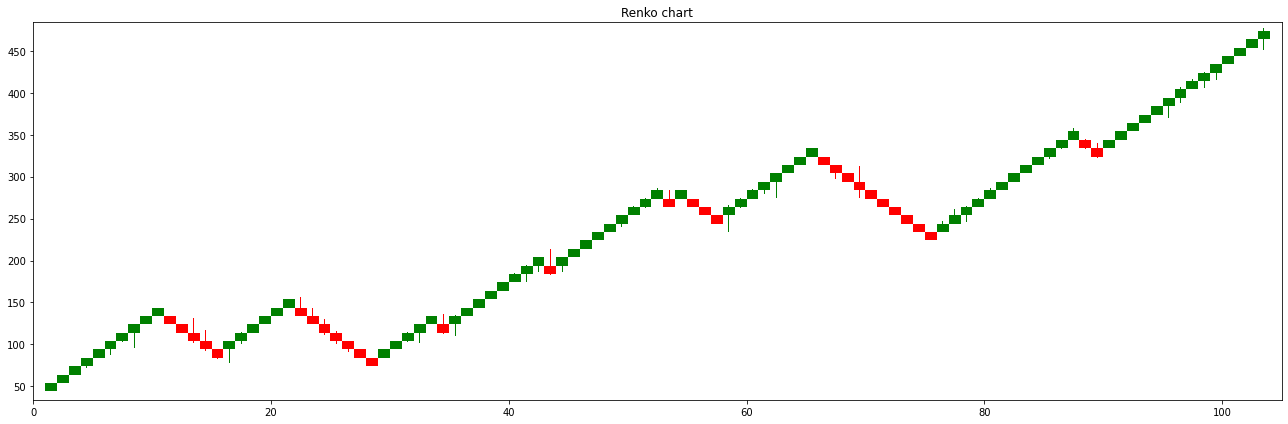

In [ ]:
renko = RenkoClassic()
classic_params = {'brick_size': 10}
renko.set_params(**classic_params)
renko_bars = renko.build_history(data)
print(renko.renko_bars)
print(renko.renko_prices[:10])
print(renko.renko_index)
renko.plot_renko('v', wicks_plot=True)

## add data to history

## add 1 point

In [ ]:
# 1 day
START = '2022-01-01'
END = '2022-01-04'
add_data = get_asset("SPY", START, END)
add_data.head(4)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,price,volume
Date,,
2022-01-03,477.709991,72668200


In [ ]:
renko.add_history(add_data)

print(renko.source_data.tail())
print(renko.renko_bars)
print(renko.renko_index)

                 price    volume
Date                            
2021-12-28  476.869995  47274600
2021-12-29  477.480011  54503000
2021-12-30  476.160004  55329000
2021-12-31  474.959991  65237400
2022-01-03  477.709991  72668200
                open     close        volume
1995-06-13   43.9375   53.9375  1.790986e+08
1996-02-05   53.9375   63.9375  6.392890e+07
1996-11-14   63.9375   73.9375  1.685217e+08
1997-05-12   73.9375   83.9375  2.369335e+08
1997-07-24   83.9375   93.9375  1.161684e+08
...              ...       ...           ...
2021-07-07  423.9375  433.9375  1.064443e+09
2021-08-12  433.9375  443.9375  1.595681e+09
2021-10-25  443.9375  453.9375  3.841138e+09
2021-11-03  453.9375  463.9375  3.999652e+08
2021-12-27  463.9375  473.9375  2.890590e+09

[103 rows x 3 columns]
[Timestamp('1993-01-29 00:00:00'), Timestamp('1995-06-13 00:00:00'), Timestamp('1996-02-05 00:00:00'), Timestamp('1996-11-14 00:00:00'), Timestamp('1997-05-12 00:00:00'), Timestamp('1997-07-24 00:00:00'), 

# add more than 1 point

In [ ]:
# 10 month
START = '2022-01-04'
END = '2022-06-01'
add_data = get_asset("SPY", START, END)
add_data.head(4)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,price,volume
Date,,
2022-01-04,477.549988,71178700
2022-01-05,468.380005,104538900
2022-01-06,467.940002,86858900
2022-01-07,466.089996,85111600


In [ ]:
renko.add_history(add_data)

print(renko.source_data.tail())
print(renko.renko_bars)
print(renko.renko_index)

                 price    volume
Date                            
2022-05-23  396.920013  76414900
2022-05-24  393.890015  91448800
2022-05-25  397.369995  91472900
2022-05-26  405.309998  81974900
2022-05-27  411.450104  14654979
                open     close        volume
1995-06-13   43.9375   53.9375  1.790986e+08
1996-02-05   53.9375   63.9375  6.392890e+07
1996-11-14   63.9375   73.9375  1.685217e+08
1997-05-12   73.9375   83.9375  2.369335e+08
1997-07-24   83.9375   93.9375  1.161684e+08
...              ...       ...           ...
2022-04-22  443.9375  433.9375  1.548092e+09
2022-04-26  433.9375  423.9375  2.236440e+08
2022-04-29  423.9375  413.9375  3.726670e+08
2022-05-09  413.9375  403.9375  8.827751e+08
2022-05-11  403.9375  393.9375  2.748582e+08

[116 rows x 3 columns]
[Timestamp('1993-01-29 00:00:00'), Timestamp('1995-06-13 00:00:00'), Timestamp('1996-02-05 00:00:00'), Timestamp('1996-11-14 00:00:00'), Timestamp('1997-05-12 00:00:00'), Timestamp('1997-07-24 00:00:00'), 

# paired_plot

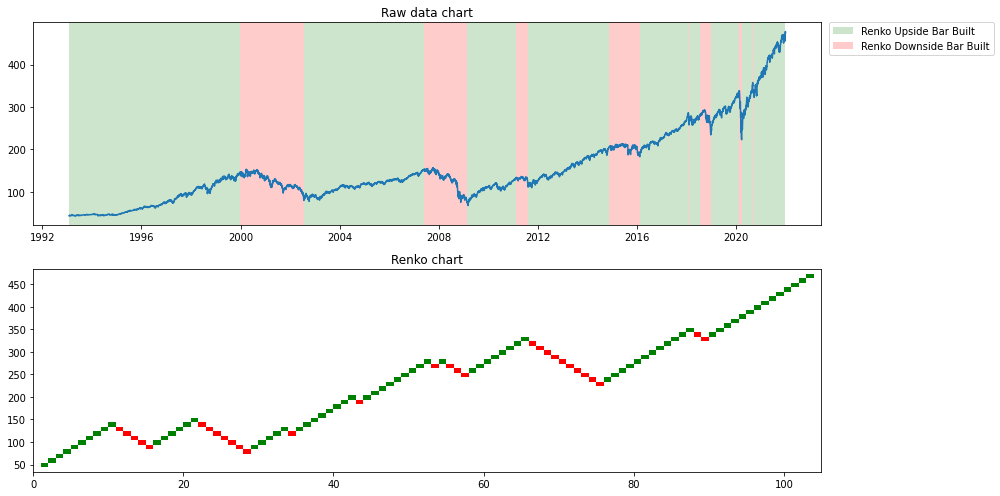

In [ ]:
renko.paired_plot_renko('', figsize=(14,7))

# timeit

In [ ]:
renko = RenkoClassic()
classic_params = {'brick_size': .5}
renko.set_params(**classic_params)

In [ ]:
%%timeit
renko_bars = renko.build_history(data)


10 loops, best of 5: 120 ms per loop


In [ ]:
len(data)

7285

In [ ]:
len(renko.renko_bars)

4

# Test RenkoFlex

In [ ]:
START = '1993-01-01'
END = '2022-01-01'
data = get_asset("SPY", START, END)
data.head(4)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,price,volume
Date,,
1993-01-29,43.93750,1003200
1993-02-01,44.25000,480500
1993-02-02,44.34375,201300
1993-02-03,44.81250,529400


                  open       close        volume
1995-02-10   43.937500   48.331250  1.579778e+08
1995-05-11   47.847938   52.681063  1.494600e+07
1995-09-08   52.154252   57.422358  2.472430e+07
1995-12-13   56.848135   62.590370  2.713600e+07
1996-09-13   61.964467   68.223504  1.536384e+08
1996-11-19   67.541269   74.363619  3.792510e+07
1997-02-13   73.619983   81.056345  1.033737e+08
1997-06-12   80.245781   88.351416  1.628969e+08
1997-10-03   87.467902   96.303043  2.872419e+08
1998-02-26   95.340013  104.970317  4.679884e+08
1998-07-01  103.920614  114.417646  4.711371e+08
1999-01-06  113.273469  124.715234  1.256472e+09
1999-04-12  123.468081  135.939605  4.726086e+08
2000-03-21  134.580209  148.174169  1.845696e+09
2001-03-12  135.926011  122.467990  1.848042e+09
2001-03-22  123.692670  111.445871  1.744374e+08
2001-09-20  112.560330  101.415742  1.455380e+09
2002-07-10  102.429900   92.288326  4.108887e+09
2002-07-22   93.211209   83.982376  4.663386e+08
2003-06-16   92.2790

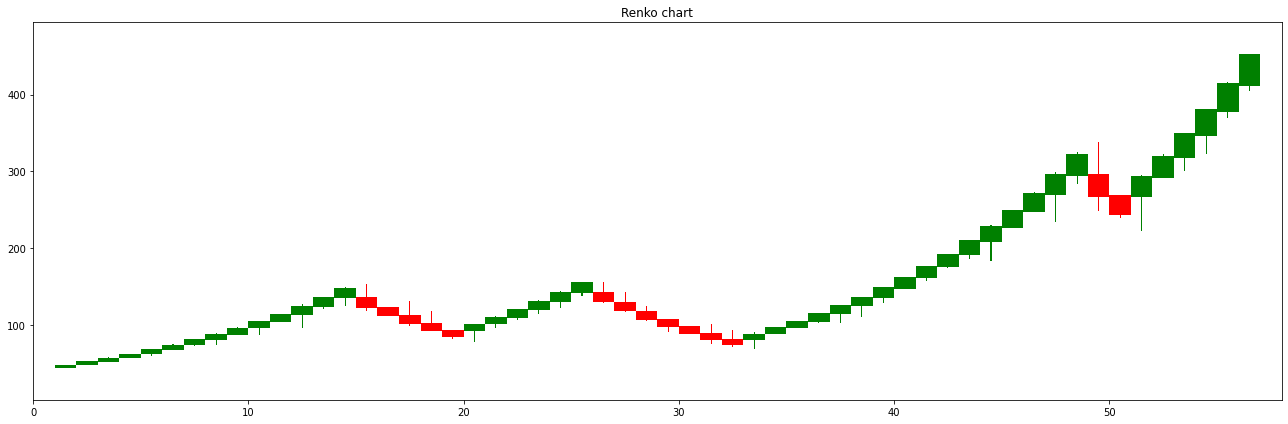

In [ ]:
# Flex Renko
flex_renko = RenkoFlex()
flex_params = {'bar_size': 0.1, 'trend_offset': 0.01, 'reversal_offset': 0.01}
flex_renko.set_params(**flex_params)
renko_bars = flex_renko.build_history(data)
print(flex_renko.renko_bars)
print(flex_renko.renko_prices[:10])
print(flex_renko.renko_index)
flex_renko.plot_renko('v', wicks_plot=True)

# Paired plot

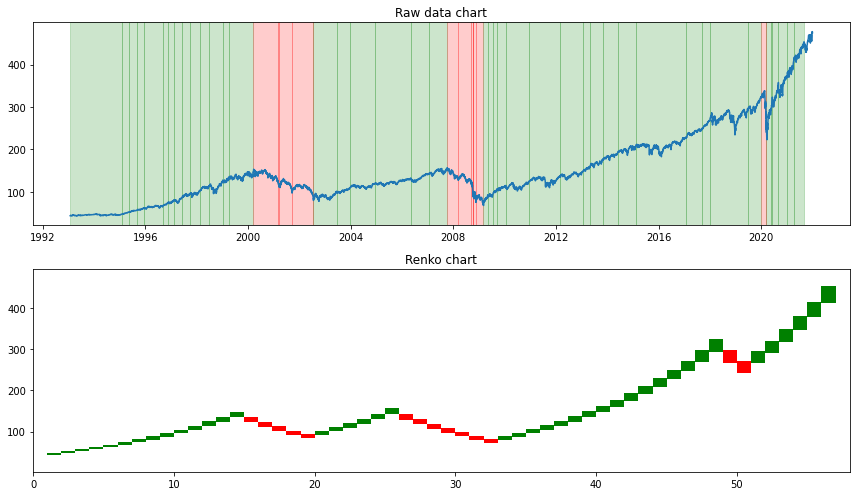

In [ ]:
flex_renko.paired_plot_renko('', figsize=(12,7))

## Add_data

# 1 day - 1 point

In [ ]:
# 1 day
START = '2022-01-01'
END = '2022-01-04'
add_data = get_asset("SPY", START, END)
add_data.head(4)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,price,volume
Date,,
2022-01-03,477.709991,72668200


In [ ]:
flex_renko.add_history(add_data)

print(flex_renko.source_data.tail())
print(flex_renko.renko_bars)


                 price    volume
Date                            
2021-12-28  476.869995  47274600
2021-12-29  477.480011  54503000
2021-12-30  476.160004  55329000
2021-12-31  474.959991  65237400
2022-01-03  477.709991  72668200
                  open       close        volume
1994-01-10   43.937500   47.452500  5.416590e+07
1995-02-14   44.605350   48.401550  1.040618e+08
1995-03-14   45.497457   49.369581  4.803000e+06
1995-03-27   46.407406   50.356973  1.146400e+06
1995-04-24   47.335554   51.364112  4.472300e+06
...                ...         ...           ...
2021-07-12  402.712298  436.985685  4.166810e+08
2021-08-13  410.766544  445.725399  1.408428e+09
2021-10-25  418.981875  454.639907  3.801668e+09
2021-11-03  427.361512  463.732705  3.999652e+08
2021-12-27  435.908743  473.007359  2.890590e+09

[385 rows x 3 columns]


# more than 1 point

In [ ]:
# 2 month
START = '2022-01-04'
END = '2022-06-01'
add_data = get_asset("SPY", START, END)
add_data.head(4)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,price,volume
Date,,
2022-01-04,477.549988,71178700
2022-01-05,468.380005,104538900
2022-01-06,467.940002,86858900
2022-01-07,466.089996,85111600


                 price    volume
Date                            
2022-05-23  396.920013  76414900
2022-05-24  393.890015  91448800
2022-05-25  397.369995  91472900
2022-05-26  405.309998  81974900
2022-05-27  410.790009   9922468
                  open       close        volume
1994-01-10   43.937500   47.452500  5.416590e+07
1995-02-14   44.605350   48.401550  1.040618e+08
1995-03-14   45.497457   49.369581  4.803000e+06
1995-03-27   46.407406   50.356973  1.146400e+06
1995-04-24   47.335554   51.364112  4.472300e+06
...                ...         ...           ...
2022-02-23  462.063267  427.190568  4.524124e+09
2022-03-08  452.822002  418.646756  1.259024e+09
2022-05-09  443.765562  410.273821  2.171249e+09
2022-05-09  434.890251  402.068345  2.171249e+09
2022-05-11  426.192446  394.026978  2.748582e+08

[390 rows x 3 columns]


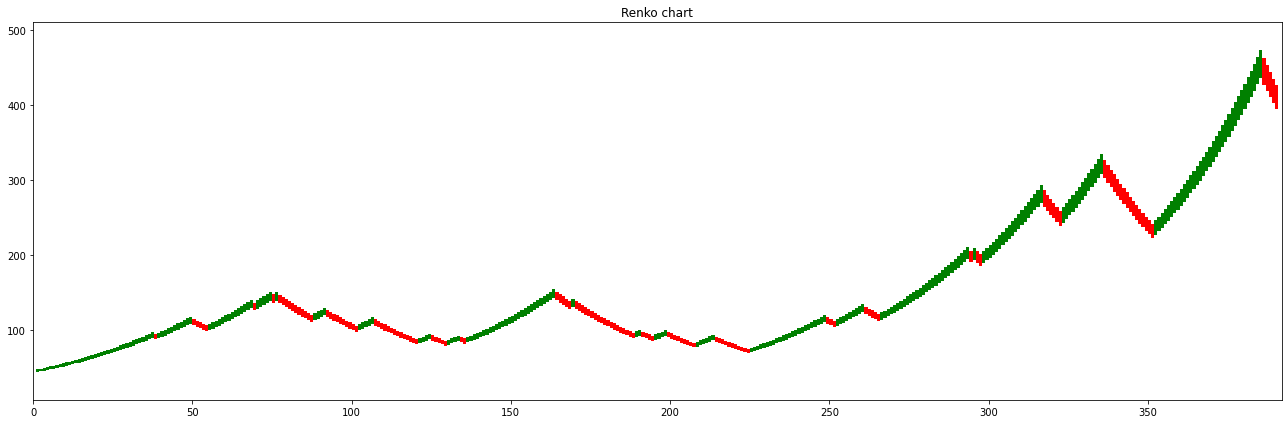

In [ ]:
flex_renko.add_history(add_data)

print(flex_renko.source_data.tail())
print(flex_renko.renko_bars)
flex_renko.plot_renko(' ')